## A quick-start to calculating catchmentwide erosion rates
This is a pre-release for the review process of the manuscript submitted to Radiocarbon.

## Setup

In [1]:
import pandas as pd
import numpy as np

import riversand

# path to the user data
path = "./user_data"

## 1. Single catchment - Example 1
### Raster data
You can add three types of raster datasets: `'elevation'`, `'shielding'` and `'quartz'`. All raster data must have the same projection and resolution.


In [2]:
# Create a new 'Riversand' object
rv = riversand.Riversand()

# Add raster data
rv.add_raster('dem_utm_35m.tif', path, dtype='elevation')
rv.add_raster('toposhielding_35m.tif', path, dtype='shielding') # optional 
#rv.add_raster('quartz_35m.tif', path, dtype='quartz') # optional

There are some **plotting** functions to quickly explore the uploaded raster data:

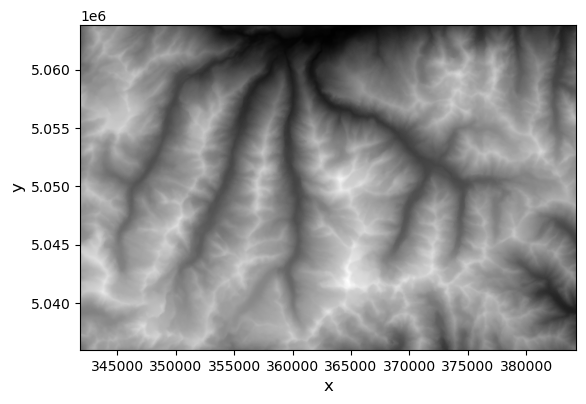

In [3]:
riversand.plot_raster(rv) # by default, the elevation raster is displayed

In [4]:
#riversand.plot_raster(rv, 'shielding') # specify, which raster to display

### Sample data
Sample and nuclide information can be added manually or imported from a spreadsheet. The requirements are those for the online calculator (see  http://hess.ess.washington.edu/math/docs/v3/v3_input_explained.html).<br>

A more detailed description is given in the multi-catchment example script.

In [5]:
# Add sample data manually
S1 = {'name'   : 'Ph-1',   # sample name
      'N'      : 1.2e6,    # nuclide concentration, atoms/gram
      'delN'   : 3.6e4,    # uncertainty, atoms/g
      'nuclide': 'Be-10',  # nuclide 'Be-10' or 'Al-26'
      'density': 1.8,      # density, g/cm3
     }
rv.add_samples(data=S1)
rv.samples # display dataset

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Ph-1,std,0,1.8,1.0,0,2010,Be-10,quartz,1200000,36000,07KNSTD


### Catchment shapefile

In [6]:
# Add catchment shapefile with a single catchment polygon
rv.add_catchments(fname='test_single_catchment.shp', path=path)

### Processing

The following parameters need to be specified:
 - `bins` : bin size for elevation statistics in metres.
 - `scaling` : scaling method as implemented in the online calculator: `'St'`, `'Lm'` or `'LSDn'.`
 - `shielding` : method for shielding correction:<br>
     - `'topo'` : compute from shielding raster; raises an error if no shielding raster is defined.<br>
     - `'sample'` : use value from sample dataset; raises an error if no shielding is defined for the sample.<br>
     - `numeric` : use a constant number between 0 and 1.
     
Optional:
 - `plot` : `'jpg'` or `'png'`; save plots with an automatically generated name.
 - `unit` : units for plots; use `riversand.params.units` to show all valid options.

Plots are saved in a folder `'./plots'` in the current working directory. Existing files with identical names will be overwritten!


In [7]:
results1 = rv.process_single_catchment(bins=100, scaling='LSDn', shielding='topo', plot='jpg', unit='mm/kyr')
results1 # display results (cm/yr)

Processing single catchment
Bin size : 100 m
Scaling method : LSDn
Topographic shielding from topo data
Saving plots as .jpg in './plots'



,name,scaling,nuclide,E,delE-,delE+,NRMSE,error
0,Ph-1,LSDn,Be-10 quartz,0.002295,0.000068,0.000072,0.000018,


In [8]:
results1.to_excel('Example1_LSDn.xlsx') # save data to spreadsheet
#results1.to_csv('Example1_LSDn.csv') # save to csv file
#results1.to_excel('Example1_LSDn.ods') # save to libre office / open office

## 2. Single catchment - example 2
Repeat the analysis with a **quartz-correction** and with a constant **shielding factor** of 0.95  

In [9]:
# Add a quartz raster dataset
rv.add_raster('quartz_35m.tif', path, dtype='quartz') # optional

In [10]:
# Set a constant shielding factor 'shielding=0.95'
results2 = rv.process_single_catchment(bins=100, scaling='LSDn', shielding=0.95)
results2 # display results (cm/yr)

Processing single catchment
Bin size : 100 m
Scaling method : LSDn
Topographic shielding : 0.95
Correcting for quartz-free lithologies

Removed 61.9 % of the catchment as quartz-free


,name,scaling,nuclide,E,delE-,delE+,NRMSE,error
0,Ph-1,LSDn,Be-10 quartz,0.001948,0.000058,0.000061,0.000112,


In [11]:
results1.to_excel('Example1_LSDn_Qtz.xlsx') # save data to spreadsheet

## 3. Multi-catchment dataset

For processing a shapefile with multiple catchment polygons, the sample data should be imported from a spreasdsheet. The spreadsheet must have a column `name`. Sample names are used to match samples data to catchment polygons. You also need to specify, which attribute field of the shapefile to use for catchment names.

In [12]:
# Create a new 'Riversand' object
rv = riversand.Riversand()

# Add raster datasets
rv.add_raster('toposhielding_35m.tif', path, dtype='shielding')
rv.add_raster('dem_utm_35m.tif', path, dtype='elevation')
rv.add_raster('quartz_35m.tif', path, dtype='quartz')

# Add sample data from a spreadsheet
rv.add_samples(fname='test_samples.ods', path=path) # .xlsx, .ods, .csv

rv.samples # display dataset; additional column such as lat, long, elev will be ignored

,name,density,shielding,nuclide,N,delN,lat,long,elev
0,DB04,2.7,0.94,Be-10,22000,1100,45.7003,7.2019,664
1,DB05,2.7,0.95,Be-10,20500,1000,45.7001,7.2337,638
2,DB06,2.7,0.95,Be-10,15400,800,45.5228,7.8375,251
3,DB08,2.7,0.96,Be-10,48500,2100,45.6118,7.7310,373
4,DB07,2.7,0.95,Be-10,22500,2600,45.5962,7.7956,325
5,DB01,2.7,0.92,Be-10,12900,700,45.8040,6.9653,1230
6,DB17,2.7,0.95,Be-10,27100,1300,45.7039,7.1622,689
7,DB03,2.7,0.94,Be-10,23500,1400,45.6925,7.1935,699
8,DB12,2.7,0.95,Be-10,12600,800,45.7183,7.2651,594
9,DB02,2.7,0.94,Be-10,10800,700,45.7167,7.1101,783


In [13]:
# Add catchment shapefile with one or several catchment polygons
rv.add_catchments(fname='test_multi_catchment.shp', path=path)

rv.catchments # display some info on the catchment data

fname : ./user_data/test_multi_catchment.shp
src   : <closed Collection './user_data/test_multi_catchment.shp:test_multi_catchment', mode 'r' at 0x7fdec71db970>
attrs : ['name', 'id', 'area_km2']
len   : 8
epsg  : 32632

In [14]:
# The shapefile has three attribute fields 'name','id', 'area_km2';
# define, which field to use:
rv.set_cid('name')

In [15]:
rv.validate()

Raster data validated.
Sample data validated.
Catchment data validated.

Catchments / samples cross-validated:
   Found 5 matche(s)


There are 10 entries in the sample spreadsheet (see `rv.samples`) and 8 polygons in the shapefile (see `rv.catchments`) but only 5 matching datasets were found.

Get the complete list of catchment names from the shapefile with `rv.catchments.get_names()`. In this example, there is no sample data for one of the catchment (DB19) and no catchment polygon for three of the samples (DB06, DB07, DB08). Catchments that have non-unique names (DB12) are also excluded. The function `rv.validate()` stores the valid cathcments in `rv.valid_catchments`.   

In [16]:
# Get all catchment names from the shapefile
rv.catchments.get_names()

['DB02', 'DB03', 'DB04', 'DB05', 'DB12', 'DB12', 'DB17', 'DB19']

In [17]:
# List of "valid" catchments (no duplicates, sample data is available)
rv.valid_catchments

['DB02', 'DB03', 'DB04', 'DB05', 'DB17']

In [18]:
# Process a multi-catchment dataset
results = rv.process_multi_catchment(bins=100, scaling='LSDn', shielding='topo', unit='mm/kyr', plot='jpg')

Processing multi-catchment dataset
Bin size : 100 m
Scaling method : LSDn
Topographic shielding from topo data
Correcting for quartz-free lithologies
Saving plots as .jpg in './plots'


 0 DB04 : 829.8+/-44.7 mm/kyr
 1 DB05 : 763.9+/-39.9 mm/kyr
 2 DB06 : no catchment polygon
 3 DB08 : no catchment polygon
 4 DB07 : no catchment polygon
 5 DB01 : no catchment polygon
 6 DB17 : 679.3+/-34.6 mm/kyr
 7 DB03 : 789.6+/-51.1 mm/kyr
 8 DB12 : no catchment polygon
 9 DB02 : catchment out of bounds


In [19]:
results # display results (cm/yr)

,name,scaling,nuclide,qtz,E,delE-,delE+,NRMSE,error
0,DB04,LSDn,Be-10 quartz,68.534972,0.082983,0.004026,0.004468,0.000224,
1,DB05,LSDn,Be-10 quartz,38.067225,0.076386,0.003608,0.003987,0.000363,
2,DB06,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
3,DB08,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
4,DB07,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
5,DB01,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
6,DB17,LSDn,Be-10 quartz,91.615061,0.06793,0.003154,0.00346,0.000014,
7,DB03,LSDn,Be-10 quartz,55.428851,0.07896,0.004502,0.005113,0.000159,
8,DB12,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,no catchment polygon
9,DB02,LSDn,Be-10 quartz,100,NaN,NaN,NaN,NaN,catchment out of bounds


In addition to the invalid catchments/samples determined above, catchment DB02 is out of bounds of the raster datasets, and no erosion rate can be calculated.

The `results` are stored in a table:

- `E`, `delE+` and `delE-` are the catchmentwide erosion rate and (asymmetric) uncertainty in cm/yr.
- `NRMSE` is the normalized root mean squared error; a warning is issued for samples with NRMSE>1e-3 indicating a poor fit of the polynomial function.
- If a quartz raster is available the column `qtz` shows the quartz-bearing area of the catchment in percent.
- `error` indicates errors that may have occurred during the calculation.


The table has the same order of samples as the input table `rv.samples` for easy merging of the spreadsheets.

Drop the empty rows with `short = results[results['E'].notna()]` if desired.

In [20]:
results.to_excel('Example2_LSDn.xlsx') # save data to spreadsheet

In [21]:
# same table without the empty rows
short = results[results['E'].notna()]
short.to_excel('Example2_LSDn_short.xlsx') # save short version to spreadsheet
short

,name,scaling,nuclide,qtz,E,delE-,delE+,NRMSE,error
0,DB04,LSDn,Be-10 quartz,68.534972,0.082983,0.004026,0.004468,0.000224,
1,DB05,LSDn,Be-10 quartz,38.067225,0.076386,0.003608,0.003987,0.000363,
6,DB17,LSDn,Be-10 quartz,91.615061,0.06793,0.003154,0.00346,0.000014,
7,DB03,LSDn,Be-10 quartz,55.428851,0.07896,0.004502,0.005113,0.000159,


## 3. Version of the online calculator

In [22]:
# Get the version of the online calculator used for the calculation
riversand.get_version() 

{'wrapper': '3.0',
 'validate': 'validate_v3_input.m - 3.0',
 'erates': '3.0',
 'muons': '3.1',
 'consts': '2022-12-03'}